In [1]:
from pyspark import SparkContext
from geopyspark.geopycontext import GeoPyContext
from geopyspark.geotrellis.catalog import read, read_value, query, write
from geopyspark.geotrellis.constants import SPATIAL, ZOOM, TILE
from geopyspark.geotrellis.geotiff_rdd import get
from geopyspark.geotrellis.rdd import RasterRDD, TiledRasterRDD
from geonotebook.vis.geotrellis.render_methods import render_nlcd, single_band_render_from_color_map
from geonotebook.wrappers import GeoTrellisCatalogLayerData, RddRasterData
import numpy as np

## Vieweing NLCD

In [14]:
M.set_center(-120.32, 47.84, 7)

In [3]:
sc = SparkContext(appName="NLCD Viewer")
geopysc = GeoPyContext(sc)

In [4]:
catalog_uri = "s3://azavea-datahub/catalog"
layer_name = "nlcd-tms-epsg3857"

In [5]:
data = GeoTrellisCatalogLayerData(geopysc, 
                                  catalog_uri, 
                                  layer_name,
                                  SPATIAL)

In [6]:
from geonotebook.vis.geotrellis.render_methods import render_nlcd

M.add_layer(data, render_tile=render_nlcd)

::1 - - [2017-05-15 06:12:18] "GET /tile/7/20/44.png HTTP/1.1" 200 171545 1.740990
::1 - - [2017-05-15 06:12:18] "GET /tile/7/20/45.png HTTP/1.1" 200 183374 0.554169
::1 - - [2017-05-15 06:12:19] "GET /tile/7/21/44.png HTTP/1.1" 200 121350 0.485863
::1 - - [2017-05-15 06:12:19] "GET /tile/7/21/45.png HTTP/1.1" 200 99974 0.472458
::1 - - [2017-05-15 06:12:20] "GET /tile/7/19/44.png HTTP/1.1" 200 32793 0.535597
::1 - - [2017-05-15 06:12:20] "GET /tile/7/20/46.png HTTP/1.1" 200 143311 0.479658
::1 - - [2017-05-15 06:12:21] "GET /tile/7/19/45.png HTTP/1.1" 200 33146 0.452182
::1 - - [2017-05-15 06:12:21] "GET /tile/7/21/43.png HTTP/1.1" 200 7016 0.408235
::1 - - [2017-05-15 06:12:22] "GET /tile/7/20/43.png HTTP/1.1" 200 8434 0.434736
::1 - - [2017-05-15 06:12:22] "GET /tile/7/21/46.png HTTP/1.1" 200 62616 0.422432
::1 - - [2017-05-15 06:12:22] "GET /tile/7/22/44.png HTTP/1.1" 200 103176 0.414063
::1 - - [2017-05-15 06:12:23] "GET /tile/7/22/45.png HTTP/1.1" 200 108991 0.473280
::1 - - [201

## Viewing reclassified tiles

In [ ]:
def reclass(x):
    # Planted/Cultivated
    # See https://www.mrlc.gov/nlcd11_leg.php
    if x >= 80 and x < 90:
        return 1
    else:
        return 0
     
cmap = { 0 : "#00000000", 1: "#CA9146FF" }
cmap_render = single_band_render_from_color_map(cmap)

def reclass_render(tile):
    arr = tile[0]
    rc = np.vectorize(reclass)
    reclassed = rc(arr)
    return cmap_render(reclassed)

In [ ]:
M.remove_layer(M.layers[0])

In [ ]:
M.add_layer(data, render_tile=reclass_render)

## Chattanooga geometry

In [15]:
!curl -o /tmp/mask.json https://s3.amazonaws.com/chattademo/chatta_mask.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  881k  100  881k    0     0  1569k      0 --:--:-- --:--:-- --:--:-- 1568k


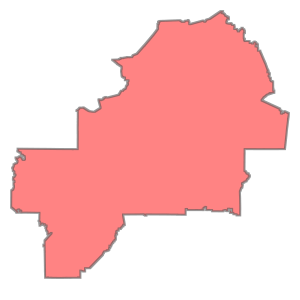

In [16]:
from functools import partial
import fiona
import json
import pyproj
from shapely.geometry import mapping, shape
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:3857'))

txt = open('/tmp/mask.json').read()
js = json.loads(txt)
geom = shape(js)
center = geom.centroid
chatta_poly = transform(project, geom)
chatta_poly

In [ ]:
M.remove_layer(M.layers[0])

In [ ]:
from geonotebook.wrappers import VectorData
vd = VectorData("/tmp/mask.json")
name = "Outline"
M.add_layer(vd, name=name)

In [17]:
M.set_center(center.x, center.y, 9)

## Fetching an RDD of NLCD masked to Chattanooga

In [ ]:
MAX_ZOOM = 12
rdd = query(geopysc, SPATIAL, catalog_uri, layer_name, 12, intersects=chatta_poly)

In [ ]:
rdd = rdd.mask([chatta_poly])
rd = RddRasterData(rdd)

In [ ]:
M.remove_layer(M.layers[0])

In [ ]:
M.add_layer(rd, render_tile=render_nlcd)

## Reclassifying an RDD

In [ ]:
nprdd = rdd.to_numpy_rdd().cache()

In [ ]:
rc = np.vectorize(reclass)
def mapper(tile):
    arr = tile['data'][0]
    tile['data'] = np.array([rc(arr)])
    return tile
reclassed = nprdd.mapValues(mapper)
gtRdd = TiledRasterRDD.from_numpy_rdd(geopysc, SPATIAL, reclassed, rdd.layer_metadata)

In [12]:
cmap = { 0 : "#00000000", 1: "#CA9146FF" }
cmap_render = single_band_render_from_color_map(cmap)
def render_tile(tile):
    arr = tile[0]
    return cmap_render(arr)

In [ ]:
rd = RddRasterData(gtRdd)

In [ ]:
M.remove_layer(M.layers[0])

In [ ]:
M.add_layer(rd, render_tile=render_tile)

## Saving the reclassified layer locally

In [8]:
local_catalog_uri = "file://catalog"

In [ ]:
# Reproject to bring the tile sizes to 256
retiled = gtRdd.reproject("EPSG:3857", scheme=ZOOM)

In [ ]:
for layer_rdd in retiled.pyramid(retiled.zoom_level, 0):
    write(local_catalog_uri, "cultivated-land-cover", layer_rdd)


## Viewing the local layer

In [9]:
data = GeoTrellisCatalogLayerData(geopysc, 
                                  local_catalog_uri, 
                                  "cultivated-land-cover",
                                  SPATIAL)

In [10]:
M.remove_layer(M.layers[0])

In [13]:
M.add_layer(data, render_tile=render_tile)

::1 - - [2017-05-15 06:12:53] "GET /tile/7/20/44.png HTTP/1.1" 500 2798 0.037672
::1 - - [2017-05-15 06:12:53] "GET /tile/7/20/45.png HTTP/1.1" 500 2798 0.008783
::1 - - [2017-05-15 06:12:53] "GET /tile/7/21/44.png HTTP/1.1" 500 2798 0.010729
::1 - - [2017-05-15 06:12:53] "GET /tile/7/19/44.png HTTP/1.1" 500 2798 0.028626
::1 - - [2017-05-15 06:12:53] "GET /tile/7/21/45.png HTTP/1.1" 500 2798 0.007479
::1 - - [2017-05-15 06:12:53] "GET /tile/7/20/46.png HTTP/1.1" 500 2798 0.005888
::1 - - [2017-05-15 06:12:53] "GET /tile/7/19/45.png HTTP/1.1" 500 2798 0.013333
::1 - - [2017-05-15 06:12:53] "GET /tile/7/21/43.png HTTP/1.1" 500 2798 0.011111
::1 - - [2017-05-15 06:12:53] "GET /tile/7/20/43.png HTTP/1.1" 500 2798 0.009073
::1 - - [2017-05-15 06:12:53] "GET /tile/7/21/46.png HTTP/1.1" 500 2798 0.014814
::1 - - [2017-05-15 06:12:53] "GET /tile/7/22/44.png HTTP/1.1" 500 2798 0.011723
::1 - - [2017-05-15 06:12:53] "GET /tile/7/22/45.png HTTP/1.1" 500 2798 0.004987
::1 - - [2017-05-15 06:12:53